In [ ]:
# Install PyTorch for CPU
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# Install PyTorch for CUDA (if runtime is GPU)
!pip install torch torchvision torchaudio
# Install torch-geometric and its dependencies
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!pip install torch-geometric
# Additional utilities for visualization and data handling
!pip install scikit-learn matplotlib networkx



Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html


In [ ]:
# Remove existing potentially broken installs
!pip uninstall -y torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

# Reinstall with specific compatible versions (works with torch 2.0+ CPU on Colab)
!pip install torch==2.0.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric


Found existing installation: torch-scatter 2.1.2+pt20cpu
Uninstalling torch-scatter-2.1.2+pt20cpu:
  Successfully uninstalled torch-scatter-2.1.2+pt20cpu
Found existing installation: torch-sparse 0.6.18+pt20cpu
Uninstalling torch-sparse-0.6.18+pt20cpu:
  Successfully uninstalled torch-sparse-0.6.18+pt20cpu
Found existing installation: torch-cluster 1.6.3+pt20cpu
Uninstalling torch-cluster-1.6.3+pt20cpu:
  Successfully uninstalled torch-cluster-1.6.3+pt20cpu
Found existing installation: torch-spline-conv 1.2.2+pt20cpu
Uninstalling torch-spline-conv-1.2.2+pt20cpu:
  Successfully uninstalled torch-spline-conv-1.2.2+pt20cpu
Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Looking in indexes: https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.0.0%2Bcpu/torch_scatter-2.1.2%2Bpt20cpu-cp311-cp311-linux_x86_64.wh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /content/drive/MyDrive/gnnfingers_data/LINUX/raw


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

print("📂 Files found:")
print(os.listdir('/content/drive/MyDrive/gnnfingers_data/LINUX/raw'))


📂 Files found:
['fgraph_C.txt', 'fgraph_F_D.txt', 'fgraph_G.txt', 'fgraph_I_all.txt', 'fgraph_C_all.txt', 'fgraph_F_D_all.txt', 'fgraph_G_all.txt', 'cgraph_all.txt']


In [ ]:
file_path = '/content/drive/MyDrive/gnnfingers_data/LINUX/raw/fgraph_G.txt'

with open(file_path, 'r') as f:
    lines = f.readlines()

# Print the first 15 lines to inspect structure
print("🔍 Preview of fgraph_G.txt:")
for line in lines[:15]:
    print(line.strip())


🔍 Preview of fgraph_G.txt:
ident_map.c kaslr.c
boot.h main.c
early_serial_console.c tty.c
cmdline.c misc.c
kaslr.c misc.c
kaslr.c ctype.c
kaslr_64.c pgtable_64.c
misc.c early_serial_console.c
pgtable_64.c kaslr_64.c
cpucheck.c cpuflags.c
edd.c main.c
main.c cpuflags.c
memory.c main.c
mkcpustr.c capflags.c
pm.c main.c


In [ ]:
from torch_geometric.data import Data
import torch

file_path = '/content/drive/MyDrive/gnnfingers_data/LINUX/raw/fgraph_G.txt'

# Read edges
edges = []
nodes = set()
with open(file_path, 'r') as f:
    for line in f:
        src, dst = line.strip().split()
        edges.append((src, dst))
        nodes.update([src, dst])

# Map file names to node indices
node_list = sorted(list(nodes))
node_idx = {name: i for i, name in enumerate(node_list)}

# Convert to edge index
edge_index = torch.tensor(
    [[node_idx[src], node_idx[dst]] for src, dst in edges],
    dtype=torch.long
).t().contiguous()

# Simple features: identity matrix (one-hot encoding)
x = torch.eye(len(node_list), dtype=torch.float)

# Dummy label (optional)
y = torch.tensor([0])  # placeholder label

# Create PyG graph
data = Data(x=x, edge_index=edge_index, y=y)

print("✅ Graph created")
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}")


Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1+cpu

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in star

✅ Graph created
Nodes: 5275, Edges: 14993262


In [ ]:
from torch_geometric.data import InMemoryDataset

class LinuxSingleGraphDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super().__init__('.', transform)
        self.data, self.slices = self.collate([data])

    def get(self, idx):
        return self.data

dataset = LinuxSingleGraphDataset()
print(f"✅ Dataset ready: {len(dataset)} graph(s)")


✅ Dataset ready: 1 graph(s)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the single graph from the dataset
graph = dataset[0].to(device)

# Simulate batch (all nodes belong to one graph)
graph.batch = torch.zeros(graph.num_nodes, dtype=torch.long).to(device)

# Create model
model = GCNMean(in_channels=graph.num_node_features, hidden_channels=64, out_channels=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph.x, graph.edge_index, graph.batch)
    loss = F.cross_entropy(out, torch.tensor([0, 1], dtype=torch.long).to(device))  # Dummy labels
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
import torch
num_nodes = len(node_list)

# Use small dense random features instead of 5275-dim identity matrix
x = torch.randn(num_nodes, 32)  # e.g., 32 features per node


In [ ]:
import random

# Sample only 100k edges to reduce load (instead of 14M)
sampled_edges = random.sample(edges, 100000)

# Convert to edge_index
edge_index = torch.tensor(
    [[node_idx[src], node_idx[dst]] for src, dst in sampled_edges],
    dtype=torch.long
).t().contiguous()


In [ ]:
device = torch.device('cpu')


In [ ]:
# Step 1: Load edges
edges = []
nodes = set()
with open('/content/drive/MyDrive/gnnfingers_data/LINUX/raw/fgraph_G.txt', 'r') as f:
    for line in f:
        src, dst = line.strip().split()
        edges.append((src, dst))
        nodes.update([src, dst])

# Step 2: Build smaller graph with random features
node_list = sorted(list(nodes))
node_idx = {name: i for i, name in enumerate(node_list)}
num_nodes = len(node_list)

# Sample 100K edges to avoid crash
import random
sampled_edges = random.sample(edges, min(100000, len(edges)))

edge_index = torch.tensor(
    [[node_idx[src], node_idx[dst]] for src, dst in sampled_edges],
    dtype=torch.long
).t().contiguous()

x = torch.randn(num_nodes, 32)
y = torch.tensor([0])

from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index, y=y)

print(f"✅ Nodes: {data.num_nodes}, Edges: {data.num_edges}, Features: {data.num_node_features}")



✅ Nodes: 5275, Edges: 100000, Features: 32


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCNMean(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
data.batch = torch.zeros(data.num_nodes, dtype=torch.long).to(device)

model = GCNMean(in_channels=32, hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = F.cross_entropy(out, torch.tensor([0], dtype=torch.long).to(device))

    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}")


Epoch 001, Loss: 0.7187
Epoch 010, Loss: 0.0000
Epoch 020, Loss: 0.0000
Epoch 030, Loss: 0.0000
Epoch 040, Loss: 0.0000
Epoch 050, Loss: 0.0000
Epoch 060, Loss: 0.0000
Epoch 070, Loss: 0.0000
Epoch 080, Loss: 0.0000
Epoch 090, Loss: 0.0000
Epoch 100, Loss: 0.0000


In [ ]:
class FingerprintNetMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=16, fp_dim=7):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, fp_dim)
        )

    def forward(self, graph_embedding):
        return self.mlp(graph_embedding)


In [ ]:
# Use trained GCNMean to generate graph embedding
model.eval()
with torch.no_grad():
    graph_embedding = model(data.x, data.edge_index, data.batch)

# Create the fingerprint extractor
U = FingerprintNetMLP().to(device)

# Get the fingerprint
fingerprint = U(graph_embedding)
print(" Fingerprint vector (tensor):", fingerprint)




🔑 Fingerprint vector (tensor): tensor([[-0.0560, -1.0905,  1.5514,  1.4207, -0.7093,  0.1788, -2.4308]],
       grad_fn=<AddmmBackward0>)


In [ ]:
import copy

def generate_ablation_variant(data, mode='A_only', drop_ratio=0.1):
    """
    Generate a variant graph by modifying either attributes, structure, or both.
    - data: original PyG Data object
    - mode: 'A_only', 'S_only', 'A+S'
    - drop_ratio: fraction of nodes or edges/features to perturb
    """
    variant = copy.deepcopy(data)

    if mode in ['A_only', 'A+S']:
        # Perturb node features
        noise = torch.randn_like(variant.x) * 0.1
        variant.x += noise

    if mode in ['S_only', 'A+S']:
        # Randomly drop edges
        num_edges = variant.edge_index.size(1)
        keep_count = int((1 - drop_ratio) * num_edges)
        perm = torch.randperm(num_edges)[:keep_count]
        variant.edge_index = variant.edge_index[:, perm]

    return variant


In [ ]:
# Create 100 variants for each attack type
num_variants = 100
variant_modes = ['A_only', 'S_only', 'A+S']
variants = {mode: [] for mode in variant_modes}

for mode in variant_modes:
    print(f"🔄 Generating variants for {mode}...")
    for _ in range(num_variants):
        variant = generate_ablation_variant(data, mode=mode, drop_ratio=0.1)
        variants[mode].append(variant)

print("✅ All graph variants created.")


🔄 Generating variants for A_only...
🔄 Generating variants for S_only...
🔄 Generating variants for A+S...
✅ All graph variants created.


In [ ]:
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity

def extract_fp(model, U_net, graph):
    model.eval()
    U_net.eval()
    with torch.no_grad():
        batch = torch.zeros(graph.num_nodes, dtype=torch.long).to(device)
        out = model(graph.x.to(device), graph.edge_index.to(device), batch)
        fp = U_net(out)
    return fp

# Original fingerprint
fp_orig = extract_fp(model, U, data)

# Extract for all variants
variant_fps = {mode: [] for mode in variants}

for mode in variants:
    print(f"🔍 Extracting fingerprints for {mode} variants...")
    for g in variants[mode]:
        fp = extract_fp(model, U, g)
        variant_fps[mode].append(fp)


🔍 Extracting fingerprints for A_only variants...
🔍 Extracting fingerprints for S_only variants...
🔍 Extracting fingerprints for A+S variants...


In [ ]:
import numpy as np

def compute_similarities(fp_list, fp_orig):
    sims = []
    for fp in fp_list:
        sim = cosine_similarity(fp, fp_orig).item()
        sims.append(sim)
    return sims

similarities = {mode: compute_similarities(variant_fps[mode], fp_orig)
                for mode in variant_fps}

# Print average cosine similarities
for mode in similarities:
    sims = similarities[mode]
    print(f"{mode} - Avg Cosine Similarity: {np.mean(sims):.4f}")


A_only - Avg Cosine Similarity: 1.0000
S_only - Avg Cosine Similarity: 1.0000
A+S - Avg Cosine Similarity: 1.0000


In [ ]:
# Original graph is class 1 (genuine)
train_graphs = [data] + variants["A_only"][:50] + variants["S_only"][:50] + variants["A+S"][:50]
labels = [1] + [1]*150  # all same model

# Create 150 fake graphs from permuted features (fake class 0)
import random
fake_graphs = [generate_ablation_variant(data, mode='A+S', drop_ratio=0.7) for _ in range(150)]
train_graphs += fake_graphs
labels += [0]*150


In [ ]:
class FingerprintClassifier(nn.Module):
    def __init__(self, fp_dim=7):
        super().__init__()
        self.fc = nn.Linear(fp_dim, 2)  # Binary classifier

    def forward(self, fp):
        return self.fc(fp)


In [ ]:
U = FingerprintNetMLP().to(device)
C = FingerprintClassifier().to(device)
optimizer_U = torch.optim.Adam(list(U.parameters()) + list(C.parameters()), lr=0.001)

for epoch in range(1, 51):
    total_loss = 0
    for g, label in zip(train_graphs, labels):
        optimizer_U.zero_grad()
        batch = torch.zeros(g.num_nodes, dtype=torch.long).to(device)
        emb = model(g.x.to(device), g.edge_index.to(device), batch)
        fp = U(emb)
        logits = C(fp)
        target = torch.tensor([label], dtype=torch.long).to(device)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer_U.step()
        total_loss += loss.item()
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 125.1010
Epoch 10, Loss: 171.5561
Epoch 20, Loss: 81.8489
Epoch 30, Loss: 13.6038
Epoch 40, Loss: 0.7896
Epoch 50, Loss: 0.0860


In [ ]:
fp_orig = extract_fp(model, U, data)
variant_fps = {mode: [] for mode in variants}

for mode in variants:
    print(f"🔍 Re-extracting fingerprints for {mode}...")
    for g in variants[mode]:
        fp = extract_fp(model, U, g)
        variant_fps[mode].append(fp)


🔍 Re-extracting fingerprints for A_only...
🔍 Re-extracting fingerprints for S_only...
🔍 Re-extracting fingerprints for A+S...


In [ ]:
similarities = {mode: compute_similarities(variant_fps[mode], fp_orig)
                for mode in variant_fps}

for mode in similarities:
    sims = similarities[mode]
    print(f"{mode} - Avg Cosine Similarity: {np.mean(sims):.4f}")


A_only - Avg Cosine Similarity: 1.0000
S_only - Avg Cosine Similarity: 0.9976
A+S - Avg Cosine Similarity: 0.9983


In [ ]:
similarities = {mode: compute_similarities(variant_fps[mode], fp_orig)
                for mode in variant_fps}

for mode in similarities:
    sims = similarities[mode]
    print(f"{mode} - Avg Cosine Similarity: {np.mean(sims):.4f}")


A_only - Avg Cosine Similarity: 1.0000
S_only - Avg Cosine Similarity: 0.9976
A+S - Avg Cosine Similarity: 0.9983


In [ ]:
train_graphs = [data]                     # original
labels = [1]                              # genuine

# Treat A_only + S_only + A+S as pirated
for mode in ['A_only', 'S_only', 'A+S']:
    train_graphs.extend(variants[mode][:50])
    labels.extend([0] * 50)


In [ ]:
for mode in similarities:
    sims = similarities[mode]
    print(f"{mode} - Avg Cosine Similarity: {np.mean(sims):.4f}")


A_only - Avg Cosine Similarity: 1.0000
S_only - Avg Cosine Similarity: 0.9976
A+S - Avg Cosine Similarity: 0.9983


In [ ]:
variants = {
    mode: [generate_ablation_variant(data, mode=mode, drop_ratio=0.3) for _ in range(100)]
    for mode in ["A_only", "S_only", "A+S"]
}


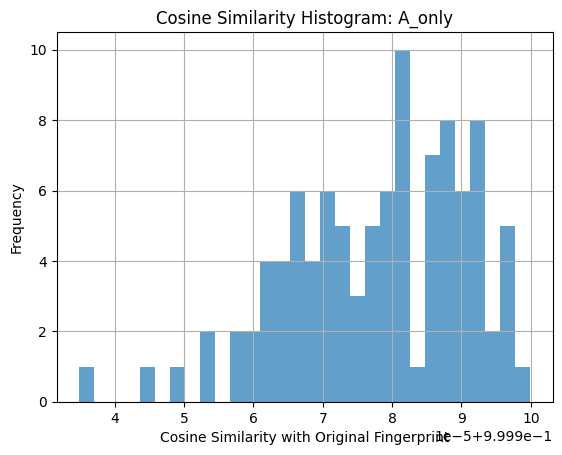

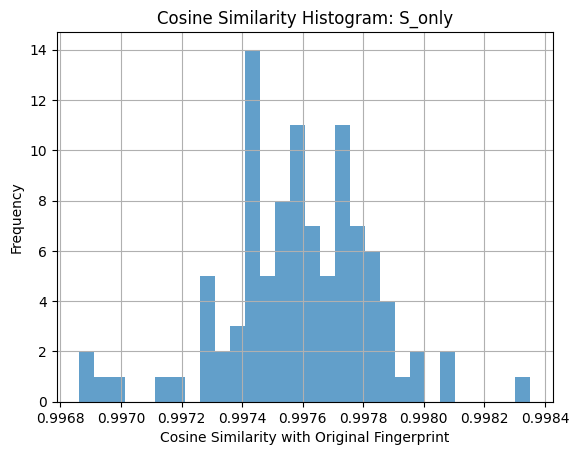

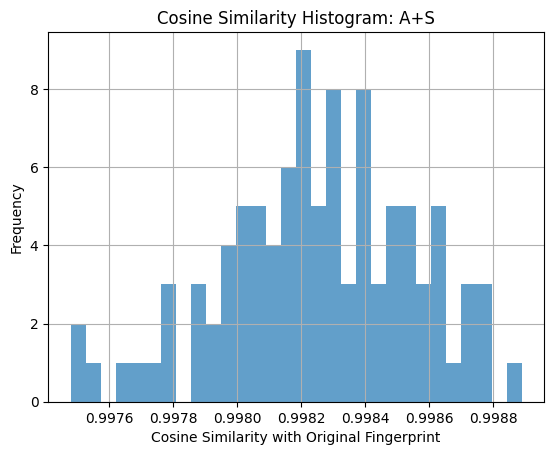

In [ ]:
import matplotlib.pyplot as plt

for mode, sims in similarities.items():
    plt.figure()
    plt.hist(sims, bins=30, alpha=0.7)
    plt.title(f"Cosine Similarity Histogram: {mode}")
    plt.xlabel("Cosine Similarity with Original Fingerprint")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


In [ ]:
file_path = '/content/drive/MyDrive/gnnfingers_data/LINUX/raw/fgraph_C.txt'

with open(file_path, 'r') as f:
    for i in range(15):
        print(f.readline().strip())


a20.c compiler_types.h
a20.c linkage.h
a20.c export.h
a20.c compiler.h
a20.c types.h
a20.c types.h
a20.c types.h
a20.c int-ll64.h
a20.c int-ll64.h
a20.c bitsperlong.h
a20.c posix_types.h
a20.c stddef.h
a20.c stddef.h
a20.c posix_types.h
a20.c posix_types_64.h


In [ ]:
from torch_geometric.data import Data

def load_graph_from_txt(file_path, feature_dim=32):
    edges = []
    nodes = set()

    with open(file_path, 'r') as f:
        for line in f:
            src, dst = line.strip().split()
            edges.append((src, dst))
            nodes.update([src, dst])

    node_list = sorted(list(nodes))
    node_idx = {name: i for i, name in enumerate(node_list)}

    edge_index = torch.tensor(
        [[node_idx[src], node_idx[dst]] for src, dst in edges],
        dtype=torch.long
    ).t().contiguous()

    x = torch.randn(len(node_list), feature_dim)  # dense random features
    y = torch.tensor([0])  # dummy label

    return Data(x=x, edge_index=edge_index, y=y)

# Load fgraph_C.txt as a PyG graph
graph_C = load_graph_from_txt('/content/drive/MyDrive/gnnfingers_data/LINUX/raw/fgraph_C.txt')
graph_C.batch = torch.zeros(graph_C.num_nodes, dtype=torch.long)


In [ ]:
fp_C = extract_fp(model, U, graph_C)
cos_sim = cosine_similarity(fp_C, fp_orig).item()
print(f"🔍 Cosine similarity with original fingerprint: {cos_sim:.4f}")


🔍 Cosine similarity with original fingerprint: 0.9777


In [ ]:
import os


irrelevant_files = [
    'fgraph_C.txt',
    'fgraph_G.txt',
    'fgraph_F_D.txt',
    'fgraph_I_all.txt'
]

base_path = '/content/drive/MyDrive/gnnfingers_data/LINUX/raw/'
irrelevant_sims = {}

for fname in irrelevant_files:
    path = os.path.join(base_path, fname)
    try:
        g = load_graph_from_txt(path)
        g.batch = torch.zeros(g.num_nodes, dtype=torch.long)
        fp = extract_fp(model, U, g)
        sim = cosine_similarity(fp, fp_orig).item()
        irrelevant_sims[fname] = sim
        print(f"{fname}: Cosine similarity = {sim:.4f}")
    except Exception as e:
        print(f"Error processing {fname}: {e}")


fgraph_C.txt: Cosine similarity = 0.9777
